Hineill David Céspedes Espinoza - 20213704

PREGUNTA 3

PASO 1

In [23]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

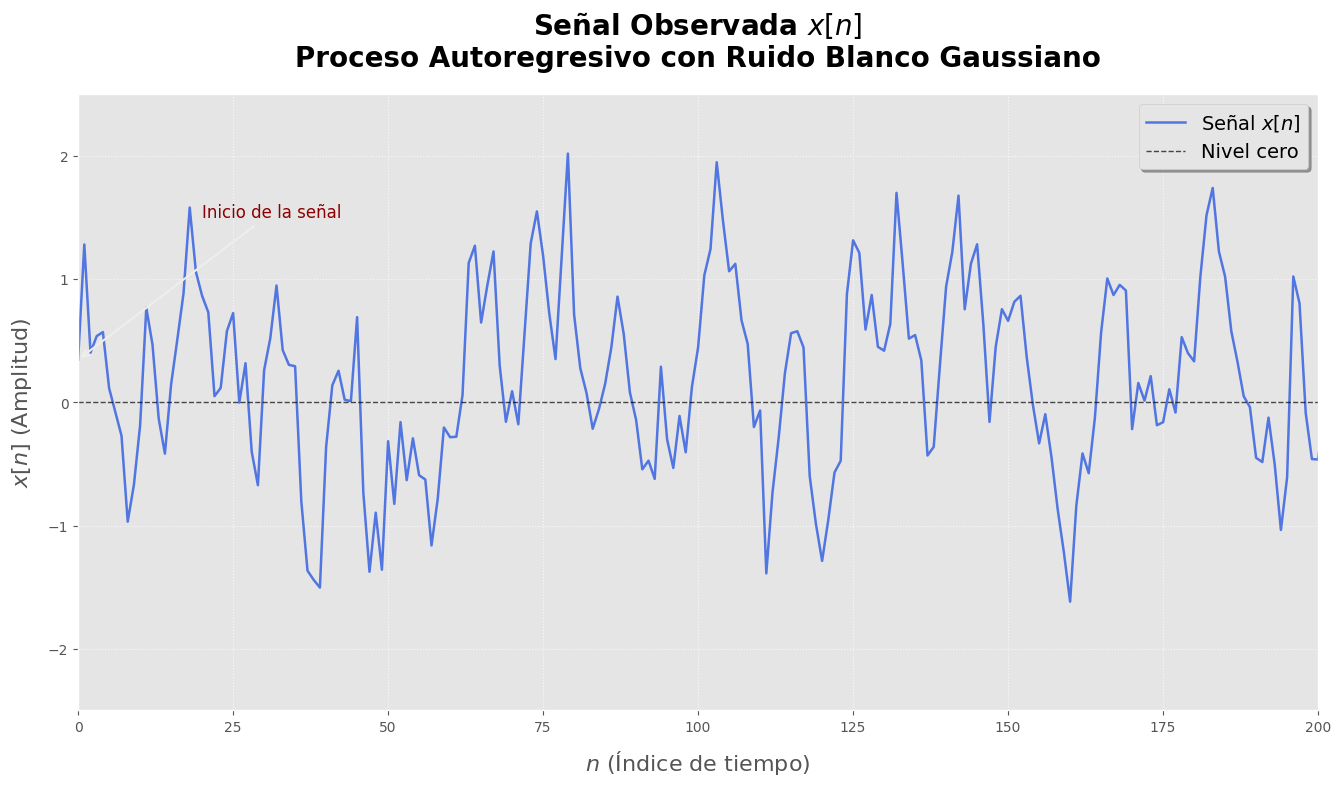

In [24]:
# Parámetros de la señal
N = 2000  # Número de muestras totales de la señal
a = [0.85, -0.15]  # Coeficientes del sistema autoregresivo
b = [1]  # Coeficiente del numerador del filtro FIR
varianza = 0.25  # Varianza del ruido blanco gaussiano que actúa como entrada

# Generar la señal x[n]
# Utilizamos un filtro IIR definido por la ecuación de diferencias:
# x[n] = 0.85 * x[n-1] - 0.15 * x[n-2] + ruido
# La función `lfilter` aplica el filtro definido por b (numerador) y a (denominador).
x = signal.lfilter(
    b,                         # Coeficientes del numerador (directo, sin dependencia de x)
    [1, -a[0], -a[1]],         # Coeficientes del denominador (definen autoregresión)
    np.sqrt(varianza) * np.random.randn(N)  # Entrada: ruido blanco gaussiano escalado
)

# Configuración de la gráfica
plt.style.use('ggplot')
plt.figure(figsize=[16, 8])

plt.plot(x, color='royalblue', linewidth=1.8, label='Señal $x[n]$', alpha=0.9)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Nivel cero')

plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.75)
plt.xlabel('$n$ (Índice de tiempo)', fontsize=16, labelpad=10)
plt.ylabel('$x[n]$ (Amplitud)', fontsize=16, labelpad=10)
plt.title('Señal Observada $x[n]$\nProceso Autoregresivo con Ruido Blanco Gaussiano', 
          fontsize=20, fontweight='bold', pad=20)
plt.xlim([0, 200])
plt.ylim([-2.5, 2.5])
plt.legend(fontsize=14, loc='upper right', frameon=True, shadow=True)

plt.annotate('Inicio de la señal', xy=(0, x[0]), xytext=(20, 1.5),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
             fontsize=12, color='darkred')

plt.show()



PASO 2

In [ ]:
#No es estrictamente necesario

PASOO 3

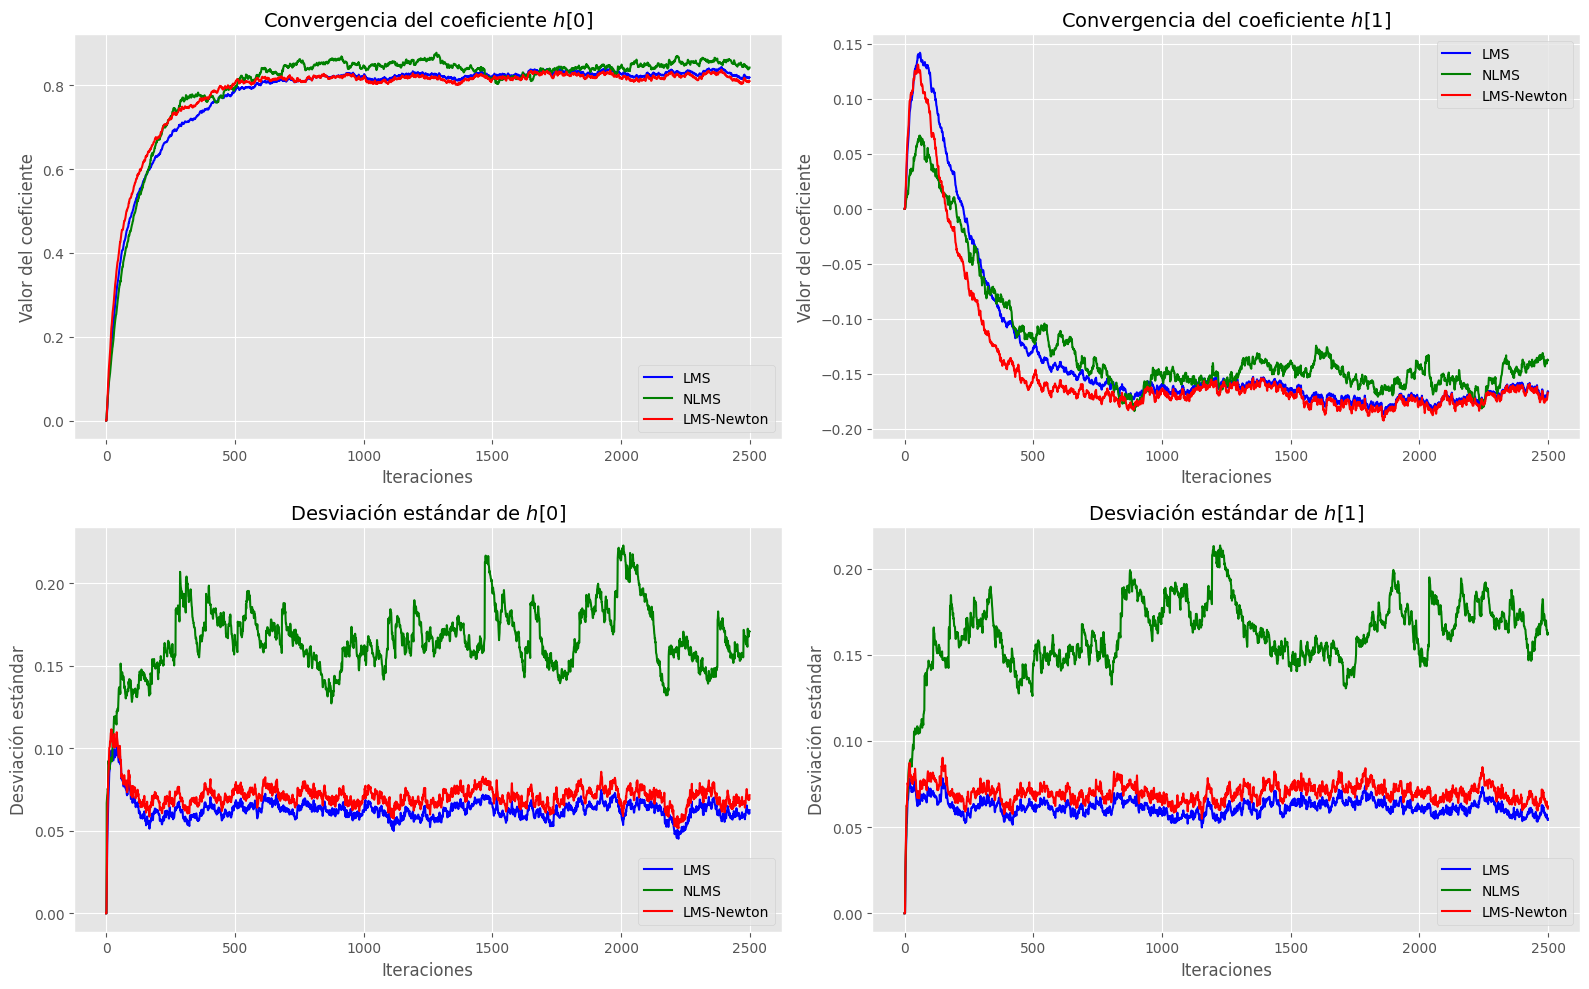

In [25]:
# Parámetros iniciales
L = 100  # Número de realizaciones para calcular estadísticas
N = 2500  # Número de muestras por realización
M = 2  # Orden del filtro predictor (número de coeficientes)

# Inicialización de matrices para almacenar los resultados
coeffs_LMS = np.zeros((M, N, L))  # Coeficientes del algoritmo LMS
predicted_LMS = np.zeros((N, L))  # Señales predichas por LMS

coeffs_NLMS = np.zeros((M, N, L))  # Coeficientes del algoritmo NLMS
predicted_NLMS = np.zeros((N, L))  # Señales predichas por NLMS

coeffs_LMSNewton = np.zeros((M, N, L))  # Coeficientes del algoritmo LMS-Newton
predicted_LMSNewton = np.zeros((N, L))  # Señales predichas por LMS-Newton

# Iteración sobre las realizaciones
for realization in range(L):
    # Generar señal autoregresiva (proceso AR)
    # Usamos un filtro AR con ruido blanco gaussiano
    input_signal = signal.lfilter(
        [1], [1, -0.85, 0.15], np.sqrt(0.25) * np.random.randn(N)
    )

    # Algoritmo LMS
    mu_LMS = 0.016  # Tasa de aprendizaje para LMS
    past_samples = np.zeros(M)  # Almacenamiento de las últimas M muestras
    for n in range(N - 1):  # Iteramos a través de las muestras
        predicted_LMS[n, realization] = np.dot(coeffs_LMS[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_LMS[n, realization]  # Error entre entrada y predicción
        coeffs_LMS[:, n + 1, realization] = coeffs_LMS[:, n, realization] + 2 * mu_LMS * error * past_samples  # Actualización de coeficientes
        past_samples = np.roll(past_samples, 1)  # Desplazar muestras hacia atrás
        past_samples[0] = input_signal[n]  # Actualizar la muestra más reciente

    # Algoritmo NLMS
    mu_NLMS = 0.01  # Tasa de aprendizaje para NLMS
    epsilon = 1e-4  # Parámetro de estabilidad numérica
    past_samples = np.zeros(M)  # Inicializamos el buffer de muestras anteriores
    for n in range(N - 1):
        predicted_NLMS[n, realization] = np.dot(coeffs_NLMS[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_NLMS[n, realization]  # Error
        coeffs_NLMS[:, n + 1, realization] = coeffs_NLMS[:, n, realization] + 2 * mu_NLMS * error * past_samples / (np.dot(past_samples, past_samples) + epsilon)  # Actualización
        past_samples = np.roll(past_samples, 1)
        past_samples[0] = input_signal[n]

    # Algoritmo LMS-Newton
    mu_LMSNewton = 0.021  # Tasa de aprendizaje para LMS-Newton
    past_samples = np.zeros(M)  # Inicializamos el buffer de muestras
    correlation_matrix = np.eye(M)  # Matriz de correlación inicial (identidad)
    inv_correlation_matrix = np.linalg.inv(correlation_matrix)  # Inversa inicial
    for n in range(N - 1):
        predicted_LMSNewton[n, realization] = np.dot(coeffs_LMSNewton[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_LMSNewton[n, realization]  # Error
        # Actualización de la matriz de correlación usando una aproximación
        correlation_matrix -= mu_LMSNewton * np.outer(
            np.dot(inv_correlation_matrix, past_samples),
            np.dot(past_samples, inv_correlation_matrix),
        )
        # Actualización de los coeficientes
        coeffs_LMSNewton[:, n + 1, realization] = coeffs_LMSNewton[:, n, realization] + 2 * mu_LMSNewton * np.dot(inv_correlation_matrix, past_samples) * error
        past_samples = np.roll(past_samples, 1)
        past_samples[0] = input_signal[n]

# Calcular promedios y desviaciones estándar de los coeficientes
mean_coeffs_LMS = np.mean(coeffs_LMS, axis=2)  # Promedio de los coeficientes LMS
mean_coeffs_NLMS = np.mean(coeffs_NLMS, axis=2)  # Promedio de los coeficientes NLMS
mean_coeffs_LMSNewton = np.mean(coeffs_LMSNewton, axis=2)  # Promedio de los coeficientes LMS-Newton

std_coeffs_LMS = np.sqrt(np.var(coeffs_LMS, axis=2))  # Desviación estándar LMS
std_coeffs_NLMS = np.sqrt(np.var(coeffs_NLMS, axis=2))  # Desviación estándar NLMS
std_coeffs_LMSNewton = np.sqrt(np.var(coeffs_LMSNewton, axis=2))  # Desviación estándar LMS-Newton

# Graficar resultados
plt.figure(figsize=[16, 10])

# Gráfica de convergencia del coeficiente h[0]
plt.subplot(2, 2, 1)
plt.plot(mean_coeffs_LMS[0, :], label='LMS', color='blue')
plt.plot(mean_coeffs_NLMS[0, :], label='NLMS', color='green')
plt.plot(mean_coeffs_LMSNewton[0, :], label='LMS-Newton', color='red')
plt.title('Convergencia del coeficiente $h[0]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Valor del coeficiente', fontsize=12)
plt.legend()

# Gráfica de convergencia del coeficiente h[1]
plt.subplot(2, 2, 2)
plt.plot(mean_coeffs_LMS[1, :], label='LMS', color='blue')
plt.plot(mean_coeffs_NLMS[1, :], label='NLMS', color='green')
plt.plot(mean_coeffs_LMSNewton[1, :], label='LMS-Newton', color='red')
plt.title('Convergencia del coeficiente $h[1]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Valor del coeficiente', fontsize=12)
plt.legend()

# Gráfica de desviación estándar del coeficiente h[0]
plt.subplot(2, 2, 3)
plt.plot(std_coeffs_LMS[0, :], label='LMS', color='blue')
plt.plot(std_coeffs_NLMS[0, :], label='NLMS', color='green')
plt.plot(std_coeffs_LMSNewton[0, :], label='LMS-Newton', color='red')
plt.title('Desviación estándar de $h[0]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Desviación estándar', fontsize=12)
plt.legend()

# Gráfica de desviación estándar del coeficiente h[1]
plt.subplot(2, 2, 4)
plt.plot(std_coeffs_LMS[1, :], label='LMS', color='blue')
plt.plot(std_coeffs_NLMS[1, :], label='NLMS', color='green')
plt.plot(std_coeffs_LMSNewton[1, :], label='LMS-Newton', color='red')
plt.title('Desviación estándar de $h[1]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Desviación estándar', fontsize=12)
plt.legend()

# Ajustar diseño de la figura
plt.tight_layout()
plt.show()



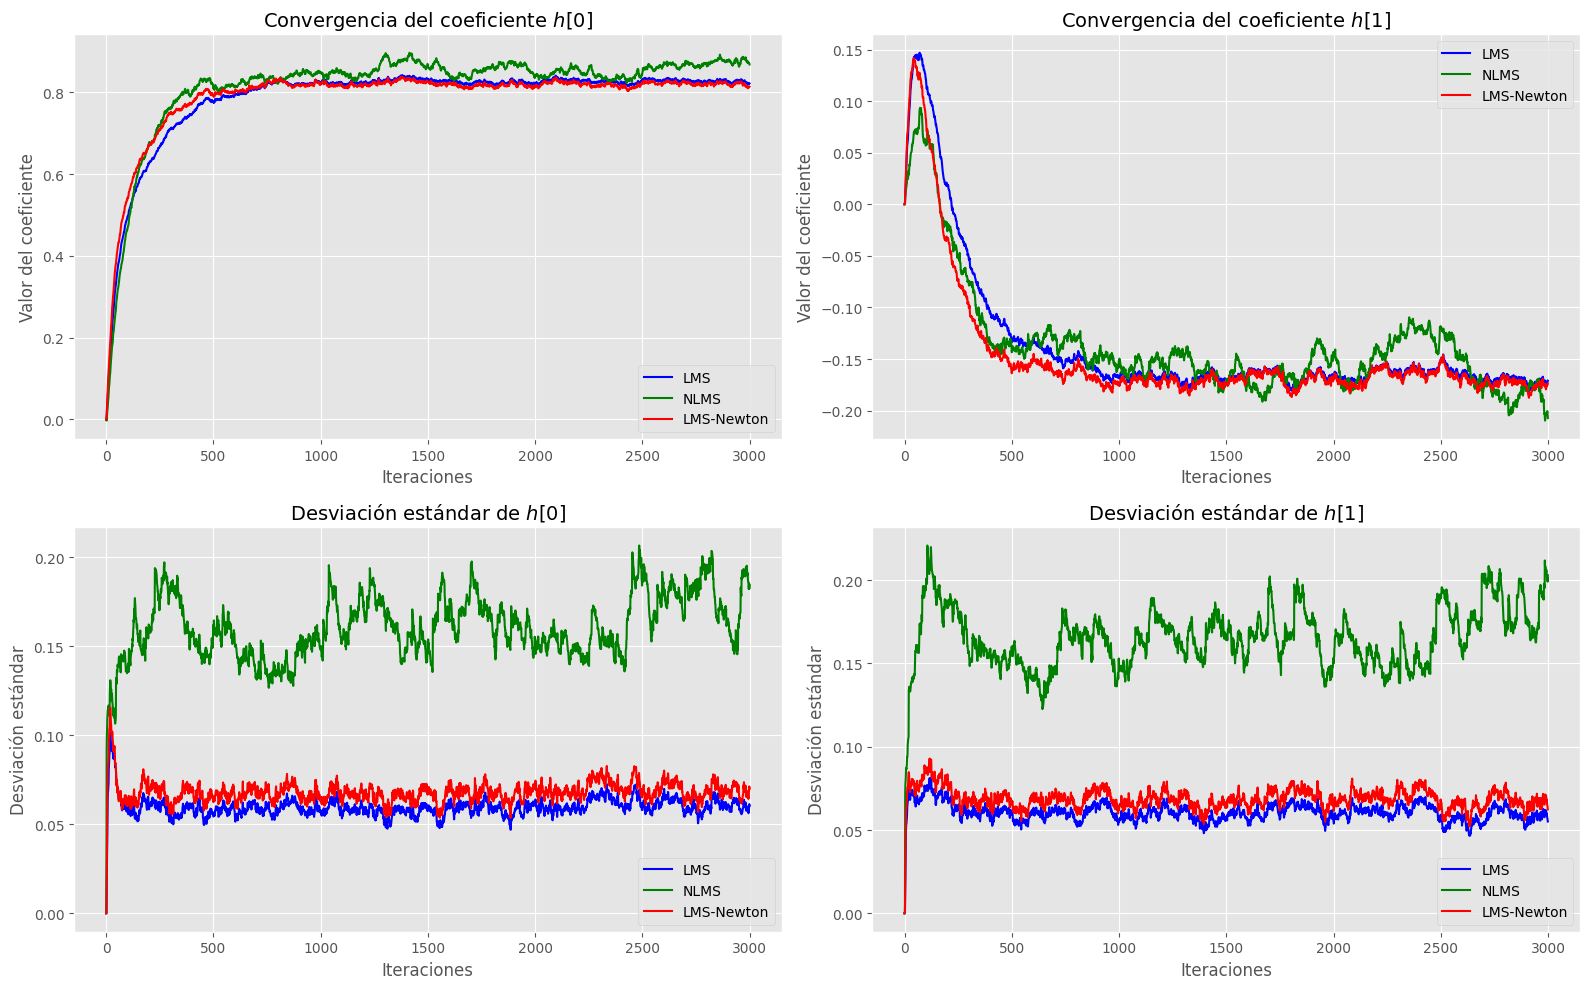

In [26]:
# Parámetros iniciales
L = 100  # Número de realizaciones para calcular estadísticas
N = 3000  # Número de muestras por realización
M = 2  # Orden del filtro predictor (número de coeficientes)

# Inicialización de matrices para almacenar los resultados
coeffs_LMS = np.zeros((M, N, L))  # Coeficientes del algoritmo LMS
predicted_LMS = np.zeros((N, L))  # Señales predichas por LMS

coeffs_NLMS = np.zeros((M, N, L))  # Coeficientes del algoritmo NLMS
predicted_NLMS = np.zeros((N, L))  # Señales predichas por NLMS

coeffs_LMSNewton = np.zeros((M, N, L))  # Coeficientes del algoritmo LMS-Newton
predicted_LMSNewton = np.zeros((N, L))  # Señales predichas por LMS-Newton

# Iteración sobre las realizaciones
for realization in range(L):
    # Generar señal autoregresiva (proceso AR)
    # Usamos un filtro AR con ruido blanco gaussiano
    input_signal = signal.lfilter(
        [1], [1, -0.85, 0.15], np.sqrt(0.25) * np.random.randn(N)
    )

    # Algoritmo LMS
    mu_LMS = 0.016  # Tasa de aprendizaje para LMS
    past_samples = np.zeros(M)  # Almacenamiento de las últimas M muestras
    for n in range(N - 1):  # Iteramos a través de las muestras
        predicted_LMS[n, realization] = np.dot(coeffs_LMS[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_LMS[n, realization]  # Error entre entrada y predicción
        coeffs_LMS[:, n + 1, realization] = coeffs_LMS[:, n, realization] + 2 * mu_LMS * error * past_samples  # Actualización de coeficientes
        past_samples = np.roll(past_samples, 1)  # Desplazar muestras hacia atrás
        past_samples[0] = input_signal[n]  # Actualizar la muestra más reciente

    # Algoritmo NLMS
    mu_NLMS = 0.01  # Tasa de aprendizaje para NLMS
    epsilon = 1e-4  # Parámetro de estabilidad numérica
    past_samples = np.zeros(M)  # Inicializamos el buffer de muestras anteriores
    for n in range(N - 1):
        predicted_NLMS[n, realization] = np.dot(coeffs_NLMS[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_NLMS[n, realization]  # Error
        coeffs_NLMS[:, n + 1, realization] = coeffs_NLMS[:, n, realization] + 2 * mu_NLMS * error * past_samples / (np.dot(past_samples, past_samples) + epsilon)  # Actualización
        past_samples = np.roll(past_samples, 1)
        past_samples[0] = input_signal[n]

    # Algoritmo LMS-Newton
    mu_LMSNewton = 0.021  # Tasa de aprendizaje para LMS-Newton
    past_samples = np.zeros(M)  # Inicializamos el buffer de muestras
    correlation_matrix = np.eye(M)  # Matriz de correlación inicial (identidad)
    inv_correlation_matrix = np.linalg.inv(correlation_matrix)  # Inversa inicial
    for n in range(N - 1):
        predicted_LMSNewton[n, realization] = np.dot(coeffs_LMSNewton[:, n, realization], past_samples)  # Predicción
        error = input_signal[n] - predicted_LMSNewton[n, realization]  # Error
        # Actualización de la matriz de correlación usando una aproximación
        correlation_matrix -= mu_LMSNewton * np.outer(
            np.dot(inv_correlation_matrix, past_samples),
            np.dot(past_samples, inv_correlation_matrix),
        )
        # Actualización de los coeficientes
        coeffs_LMSNewton[:, n + 1, realization] = coeffs_LMSNewton[:, n, realization] + 2 * mu_LMSNewton * np.dot(inv_correlation_matrix, past_samples) * error
        past_samples = np.roll(past_samples, 1)
        past_samples[0] = input_signal[n]

# Calcular promedios y desviaciones estándar de los coeficientes
mean_coeffs_LMS = np.mean(coeffs_LMS, axis=2)  # Promedio de los coeficientes LMS
mean_coeffs_NLMS = np.mean(coeffs_NLMS, axis=2)  # Promedio de los coeficientes NLMS
mean_coeffs_LMSNewton = np.mean(coeffs_LMSNewton, axis=2)  # Promedio de los coeficientes LMS-Newton

std_coeffs_LMS = np.sqrt(np.var(coeffs_LMS, axis=2))  # Desviación estándar LMS
std_coeffs_NLMS = np.sqrt(np.var(coeffs_NLMS, axis=2))  # Desviación estándar NLMS
std_coeffs_LMSNewton = np.sqrt(np.var(coeffs_LMSNewton, axis=2))  # Desviación estándar LMS-Newton

# Graficar resultados
plt.figure(figsize=[16, 10])

# Gráfica de convergencia del coeficiente h[0]
plt.subplot(2, 2, 1)
plt.plot(mean_coeffs_LMS[0, :], label='LMS', color='blue')
plt.plot(mean_coeffs_NLMS[0, :], label='NLMS', color='green')
plt.plot(mean_coeffs_LMSNewton[0, :], label='LMS-Newton', color='red')
plt.title('Convergencia del coeficiente $h[0]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Valor del coeficiente', fontsize=12)
plt.legend()

# Gráfica de convergencia del coeficiente h[1]
plt.subplot(2, 2, 2)
plt.plot(mean_coeffs_LMS[1, :], label='LMS', color='blue')
plt.plot(mean_coeffs_NLMS[1, :], label='NLMS', color='green')
plt.plot(mean_coeffs_LMSNewton[1, :], label='LMS-Newton', color='red')
plt.title('Convergencia del coeficiente $h[1]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Valor del coeficiente', fontsize=12)
plt.legend()

# Gráfica de desviación estándar del coeficiente h[0]
plt.subplot(2, 2, 3)
plt.plot(std_coeffs_LMS[0, :], label='LMS', color='blue')
plt.plot(std_coeffs_NLMS[0, :], label='NLMS', color='green')
plt.plot(std_coeffs_LMSNewton[0, :], label='LMS-Newton', color='red')
plt.title('Desviación estándar de $h[0]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Desviación estándar', fontsize=12)
plt.legend()

# Gráfica de desviación estándar del coeficiente h[1]
plt.subplot(2, 2, 4)
plt.plot(std_coeffs_LMS[1, :], label='LMS', color='blue')
plt.plot(std_coeffs_NLMS[1, :], label='NLMS', color='green')
plt.plot(std_coeffs_LMSNewton[1, :], label='LMS-Newton', color='red')
plt.title('Desviación estándar de $h[1]$', fontsize=14)
plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Desviación estándar', fontsize=12)
plt.legend()

# Ajustar diseño de la figura
plt.tight_layout()
plt.show()